## 1. Business Understanding

### Overview

The dataset we will be using is a collection of amazon reviews for instant video products found at http://jmcauley.ucsd.edu/data/amazon/. Our set includes the reviews’ product, reviewer, text review, rating, helpfulness/unhelpfulness, and other metadata. The specific dataset we are using is a “5-core” dataset meaning that it includes only products and reviewers that have more than 5 reviews on amazon. This means that each product in this dataset has at least 5 reviews and that each reviewer in this dataset has posted at least 5 reviews for this category. The set includes over 37,000 reviews. 

### Purpose

This data was originally collected by Amazon as consumers browsed, bought, and reviewed products. This data is necessary for amazon to be able to display the reviews on each product. The specific dataset we are using however is UCSD’s collection that has been structured by two researchers (Julian McAuley, Alex Yang) to understand why and what reviews are helpful to consumers when it comes to purchasing an object. They outline more in detail their findings with this data in the following paper: http://cseweb.ucsd.edu/~jmcauley/pdfs/www16b.pdf

### Prediction Task

Reviews have become increasingly crucial in consumer purchase decisions. As discussed in a BrightLocal study, 88% of consumers incorporate reviews into their purchase decisions. This finding for most consumers is obvious. Reviews have become ubiquitous on many e-commerce sites. Another finding that is less intuitive is that consumers are starting to base decisions on less reviews now. It was found that between one and three bad online reviews would be enough to deter the majority (67%) of shoppers from purchasing a product or service. Furthermore, 73% of consumers form an opinion by reading up to six reviews ,vs. 64% in 2014 and 40% of consumers form an opinion by reading just one to three reviews vs. 29% in 2014. 
Consumers are basing decisions on less reviews. This trend introduces unique issues, for example, what if the first few reviews a consumer reads are not very helpful? What if all of the reviews on a product are unhelpful? This puts a premium on presenting and identifying useful reviews. If a company could know beforehand which types of reviews are helpful, they could enforce those attributes as rules or they could promote those reviews before other unhelpful reviews. 
Given this scenario, our prediction task for this data is the to determine the helpfulness [helpfulness ratio?] of a review. 

### Third Parties

The parties interested in this result would include e-commerce vendors (Amazon, eBay, Alibaba, etc..) that offer reviews on products. This could give them insight on what reviews are generally helpful and how they can get these reviews in front of consumers before other reviews to help with product conversion. This would also allow them to enforce potential rules on reviews to remove unhelpful reviews that would not be helpful and potentially detrimental to product conversion. It would also help with products that do not yet have many reviews where the normal process of voting has not taken place yet. 
More third parties that would be interested in the data(although not specifically these findings) include advertisers, that would benefit from a text analysis of the reviews to see what relating products or needs are mentioned. They could use this information to know when to advertise certain products. Consumers will benefit from having more helpful reviews. 


### Sources
BrightLocal, Business2community, Bazaarvoice, webrepublic, reprevive, Econsultancy,business2community,Reevoo and Social Media Today:
https://www.vendasta.com/blog/50-stats-you-need-to-know-about-online-reviews

Forbes 
https://www.forbes.com/sites/jaysondemers/2015/12/28/how-important-are-customer-reviews-for-online-marketing/#276bfb421928


## 2. Data understanding

In [89]:
#Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

print(sys.version)
print(np.__version__)

plt.style.use('seaborn-deep')

#load dataset
dataframe = pd.read_json('reviews_Amazon_Instant_Video_5.json',lines=True)
dataframe.info()

3.6.4 (v3.6.4:d48eceb, Dec 19 2017, 06:54:40) [MSC v.1900 64 bit (AMD64)]
1.14.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 9 columns):
asin              37126 non-null object
helpful           37126 non-null object
overall           37126 non-null int64
reviewText        37126 non-null object
reviewTime        37126 non-null object
reviewerID        37126 non-null object
reviewerName      36797 non-null object
summary           37126 non-null object
unixReviewTime    37126 non-null int64
dtypes: int64(2), object(7)
memory usage: 2.5+ MB


### 2.1. Data types
The features of this dataset are as follows :
+ asin - ID of the product - Nominal
+ helpful - A tuple containing the number of people that thought the review was helpful or unhelpful - Both ordinal, stored as integers
+ overall - The overall rating that a product received. Ordinal, stored as integer
+ reviewText - The full text of the review - Bag of words
+ reviewTime - The timestamp of the review - Interval
+ reviewerID - The ID of the reviewer - Nominal
+ reviewerName - The name of the reviewer - Nominal
+ summary - A summary of the review  - Bag of words
+ unixReviewTime - The UNIX timestamp of the review - Interval
   


Additionally, we extracted the following attributes from the already existing attributes that will help us in our analysis of the dataset :
+ numberHelpful - The amount of people that thought the review was helpful, extracted from the helpful tuple. Ordinal, stored as integer
+ numberUnhelpful - The amount of people that thought the review was unhelpful, extracted from the helpful tuple. Ordinal, stored as integer
+ reviewerNumberReviews - The number of reviews each reviewer had left. Ordinal, stored as integer
+ reviewLength  - The length of the review text. Ordinal, stored as integer


In [77]:
#extract information for number of reviews by each reviewer
reviewer_ids = list(dataframe['reviewerID'])
authorToNumReviews = {user_id:reviewer_ids.count(user_id) for user_id in set(reviewer_ids)}
dataframe['reviewLength'] = [len(text) for text in dataframe['reviewText']]
dataframe['reviewerNumberReviews'] = [authorToNumReviews[author] for author in dataframe['reviewerID']]

#extract additional columns for analysis
helpful_count = []
unhelpful_count = []
helpful_ratio = []
for (h,total) in dataframe['helpful']:
    helpful_count.append(h)
    unhelpful_count.append(total-h)
    if total == 0:
        helpful_ratio.append(None)
    else:
        helpful_ratio.append(h/(total))
dataframe['numberUnhelpful'] = unhelpful_count
dataframe['numberHelpful'] = helpful_count
dataframe['helpfulRatio'] = helpful_ratio

### Bag of Words Analysis

An additional point of interest in this data set is the possibility of finding relationships between the language used in reviews and whether that relates to the overall rating of the reviews or potentially overall helpfulness. Uses of this knowledge could be to predict helpfulness or rating when applied to a large set or to identify quickly what is upsetting or exciting consumers if grouped by individual products.

First, what we will do is examine the language used in each review grouped by the overall rating the review gave. This maygive us insight into what words were most popular with certain review ratings. 

In [148]:
from sklearn.feature_extraction.text import CountVectorizer


df_grouped = dataframe.groupby(by="overall")
df_dict = {}

for x in range(5):
    x += 1
    df_group = df_grouped.get_group(x)
    count_vect_review = CountVectorizer(stop_words='english')
    count_vect_summary = CountVectorizer(stop_words='english')
    review_bag = count_vect_review.fit_transform(df_group['reviewText'])
    summary_bag = count_vect_summary.fit_transform(df_group['summary'])
    df_inner_dict = {
        "count_vect_review":count_vect_review,
        "count_vect_summary":count_vect_summary,
        "review_bag":review_bag,
        "summary_bag":summary_bag
    }
    df_dict[x] = df_inner_dict

We will examine the review bag closely to understand the words used in reviews and see if we can find any insights

In [152]:
for key in df_dict.keys():
    df = pd.DataFrame(data=df_dict[key]["summary_bag"].toarray(),columns=df_dict[key]["count_vect_summary"].get_feature_names())
    
    #Printing the most common words in the data
    print("10 Most common words in",key,"star review titles.\n\n",df.sum().sort_values()[-10:],"\n\n")

10 Most common words in 1 star review titles.

 awful     40
like      41
season    44
good      45
just      47
time      49
don       51
movie     58
bad       72
boring    85
dtype: int64 


10 Most common words in 2 star review titles.

 better     38
really     45
bad        48
great      49
season     52
just       56
boring     60
movie      65
like       71
good      101
dtype: int64 


10 Most common words in 3 star review titles.

 just            97
okay           101
interesting    117
better         118
movie          122
like           126
great          163
ok             178
season         238
good           390
dtype: int64 


10 Most common words in 4 star review titles.

 better          196
movie           209
love            212
like            264
fun             315
interesting     329
series          384
season          518
great           591
good           1158
dtype: int64 


10 Most common words in 5 star review titles.

 awesome       453
tv            461


That gave a good idea of raw coun in each different review, but there is a fair deal of overlap between the most frequent words accross both groups. Furthermore these findings relate mostly to how the consumer felt. Potentialy finding the TF/IDF for each word will give a better result and help identify specific charachteristics of videos that made it receive good or bad reviews.

In this next section we will find the top 10 words ranked by TF/IDF in the review documents grouped by star rating.

In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer

df_dict_tfidf = {}

for x in range(5):
    x += 1
    df_group = df_grouped.get_group(x)
    tfidf_vect_review = TfidfVectorizer(stop_words='english',max_df=0.01,min_df=4)
    tfidf_vect_summary = TfidfVectorizer(stop_words='english',max_df=0.01,min_df=4)
    review_bag = tfidf_vect_review.fit_transform(df_group['reviewText'])
    summary_bag = tfidf_vect_summary.fit_transform(df_group['summary'])
    df_inner_dict = {
        "tfidf_vect_review":tfidf_vect_review,
        "tfidf_vect_summary":tfidf_vect_summary,
        "review_bag":review_bag,
        "summary_bag":summary_bag
    }
    df_dict_tfidf[x] = df_inner_dict

In [179]:
for key in df_dict_tfidf.keys():
    df = pd.DataFrame(data=df_dict_tfidf[key]["review_bag"].toarray(),columns=df_dict_tfidf[key]["tfidf_vect_review"].get_feature_names())
    
    #Printing the most common words in the data
    print("10 Most unique words in",key,"star review titles by TF/IDF.\n\n",df.max().sort_values()[-10:],"\n\n")

10 Most unique words in 1 star review titles by TF/IDF.

 nude          1.0
offer         1.0
officially    1.0
ordering      1.0
paint         1.0
parenthood    1.0
pc            1.0
phone         1.0
minions       1.0
zombies       1.0
dtype: float64 


10 Most unique words in 2 star review titles by TF/IDF.

 robot           1.0
executed        1.0
ridiculously    1.0
unfunny         1.0
excited         1.0
depressing      1.0
syfy            1.0
responses       1.0
alright         1.0
bother          1.0
dtype: float64 


10 Most unique words in 3 star review titles by TF/IDF.

 faults      1.0
twins       1.0
fare        1.0
ran         1.0
random      1.0
faint       1.0
rave        1.0
fails       1.0
hill        1.0
finished    1.0
dtype: float64 


10 Most unique words in 4 star review titles by TF/IDF.

 sarcastic    1.0
liking       1.0
twisty       1.0
likes        1.0
likeable     1.0
typically    1.0
likable      1.0
florida      1.0
twice        1.0
ninety       1.0
dtyp

Here we see that there seems to be distinctions rising in this new set of information. For example, many 1 star reviews had minions and zombies as important words. This may propose that these elements in movies lead to many controvertial opinions. 

Applying this analysis to one specific product may yeild what it was about that specific product that excited or bored viewers.
In this next section we will do the same TF/IDF analysis as above but only on one product.

In [264]:
#Finding the most reviewed Product
data_products = dataframe.groupby(by=["asin"])
prod_count = data_products.overall.count()
prod_max = prod_count.max()
prod_count = prod_count.reset_index()
max_product = prod_count[prod_count['overall'] == prod_max]
max_product_asin = max_product['asin'].tolist()[0]
print (max_product)

df_product_grouped = dataframe.groupby(by=["overall","asin"])

            asin  overall
1557  B00I3MPDP4      455


In [267]:
df_dict_tfidf_product = {}
for x in range(5):
    x += 1
    df_product_group = df_product_grouped.get_group((x,max_product_asin))
    tfidf_vect_review_product = TfidfVectorizer(stop_words='english')
    tfidf_vect_summary_product = TfidfVectorizer(stop_words='english')

    review_bag_product = tfidf_vect_review_product.fit_transform(df_product_group['reviewText'])
    summary_bag_product = tfidf_vect_summary_product.fit_transform(df_product_group['summary'])
    df_inner_dict = {
        "tfidf_vect_review_product":tfidf_vect_review_product,
        "tfidf_vect_summary_product":tfidf_vect_summary_product,
        "review_bag_product":review_bag_product,
        "summary_bag_product":summary_bag_product
    }
    df_dict_tfidf_product[x] = df_inner_dict
print (df_dict_tfidf_product[2]['review_bag_product'])

  (0, 200)	0.2876389870877477
  (0, 348)	0.12375627413765689
  (0, 385)	0.12375627413765689
  (0, 27)	0.12375627413765689
  (0, 10)	0.16721265471037378
  (0, 222)	0.16721265471037378
  (0, 72)	0.12375627413765689
  (0, 237)	0.16721265471037378
  (0, 96)	0.1479828999677206
  (0, 12)	0.16721265471037378
  (0, 351)	0.16721265471037378
  (0, 245)	0.12375627413765689
  (0, 218)	0.16721265471037378
  (0, 180)	0.13433917184788896
  (0, 336)	0.16721265471037378
  (0, 3)	0.16721265471037378
  (0, 41)	0.16721265471037378
  (0, 224)	0.16721265471037378
  (0, 303)	0.1479828999677206
  (0, 344)	0.16721265471037378
  (0, 2)	0.16721265471037378
  (0, 236)	0.16721265471037378
  (0, 357)	0.13433917184788896
  (0, 103)	0.12375627413765689
  (0, 193)	0.16721265471037378
  :	:
  (23, 315)	0.12447956799577001
  (23, 320)	0.13512431747851372
  (23, 374)	0.14884778640194987
  (23, 295)	0.14884778640194987
  (23, 227)	0.14884778640194987
  (23, 185)	0.14884778640194987
  (23, 256)	0.13512431747851372
  (23, 2

In [275]:
for key in df_dict_tfidf_product.keys():
    df = pd.DataFrame(data=df_dict_tfidf_product[key]["review_bag_product"].toarray(),columns=df_dict_tfidf_product[key]["tfidf_vect_review_product"].get_feature_names())
    
    #Printing the most common words in the data
    print("10 Most unique words in",key,"star review titles by TF/IDF.\n\n",df.max().sort_values()[-10:],"\n\n")

10 Most unique words in 1 star review titles by TF/IDF.

 match       0.360242
twisted     0.365457
appeal      0.365457
mind        0.365457
little      0.365457
value       0.365457
say         0.365457
got         0.383532
swearing    0.412176
sentence    0.412176
dtype: float64 


10 Most unique words in 2 star review titles by TF/IDF.

 entire       0.389515
execution    0.430608
pilot        0.434033
fight        0.440131
live         0.440131
paced        0.440131
bit          0.471637
crazy        0.471637
ok           0.471637
slow         0.490745
dtype: float64 


10 Most unique words in 3 star review titles by TF/IDF.

 season      0.437702
action      0.437702
viewer      0.467491
lawyer      0.479176
series      0.479840
killed      0.485558
rest        0.520277
complain    0.556306
8217        0.561251
develop     0.640871
dtype: float64 


10 Most unique words in 4 star review titles by TF/IDF.

 short       0.537796
husband     0.546431
new         0.548929
lot        

This breaks out the top TF/IDF words accross a single product, and it suggests that many of the 1-star reviews came from the vulgarity or swearing in the show. This is an example how this can be useful not only accross a range of products but even for a single product. The company that makes this show can then very quickly see that vulgarity is upsetting some of their viewers and then they can decide whether or not it makes sense for them to change that

<br/> 
We discarded the attributes we would not need for our analysis and set the appropriate storage types to those that were not already assigned. 
<br/>

In [91]:
import numpy as np
unneeded_attributes = ['unixReviewTime', 'helpful', 'reviewTime']
ordinal_attributes = ['numberHelpful', 'numberUnhelpful', 'reviewLength', 'overall', 'reviewerNumberReviews']
nominal_attributes = ['asin', 'reviewerID', 'reviewerName']

for attr in unneeded_attributes:
    if attr in dataframe:
        del dataframe[attr]

dataframe[ordinal_attributes] = dataframe[ordinal_attributes].astype(np.int64)
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37126 entries, 0 to 37125
Data columns (total 10 columns):
asin                     37126 non-null object
overall                  37126 non-null int64
reviewText               37126 non-null object
reviewerID               37126 non-null object
reviewerName             36797 non-null object
summary                  37126 non-null object
numberUnhelpful          37126 non-null int64
numberHelpful            37126 non-null int64
reviewLength             37126 non-null int64
reviewerNumberReviews    37126 non-null int64
dtypes: int64(5), object(5)
memory usage: 2.8+ MB


### 2.2. Data quality

The dataset that was provided was not missing any values for the attributes we wanted to use. It was, however, missing 329 reviewer names, as can be seen from the outputs above and below. We decided to keep this data as is, as there was another unique identifier for reviewers - reviewerID - that we could use to associate a reviewer with a review. Reviewer names were also not a part of our analysis or predicition, so it would in no way skew our results at the end. 
<br/>
The most probable reason why there were missing values for reviewerName is that Amazon had given the option to reviewers to post anonymously and had hidden their names in the review. Since only logged in members are allowed to post reviews, we can assume that the reviewerID is sufficient for us to identify reviews by the same members.

In [97]:
null_data = dataframe[dataframe.isnull().any(axis=1)]
len(null_data)
#pd.get_dummies(dataframe.reviewerID)

329

<br/> 
Furthermore, we decided to not treat entries where numberHelpful and numberUnhelpful were 0 as missing, as it was not an erroneous entry of information, but could signify that simply no other customers found this review to be helpful or unhelpful and could damage our final result, should we choose to delete or impute these values. It can be seen that over 50% of the values have 0 for those two attributes. 
<br/>

In [93]:
dataframe.describe()

,overall,numberUnhelpful,numberHelpful,reviewLength,reviewerNumberReviews
count,37126.00000,37126.000000,37126.000000,37126.000000,37126.000000
mean,4.20953,2.019016,1.293541,515.292033,25.152562
std,1.11855,10.086076,8.301778,835.145610,88.755763
min,1.00000,0.000000,0.000000,4.000000,1.000000
25%,4.00000,0.000000,0.000000,145.000000,5.000000
50%,5.00000,0.000000,0.000000,232.000000,7.000000
75%,5.00000,1.000000,1.000000,484.000000,11.000000
max,5.00000,512.000000,484.000000,18152.000000,645.000000


<br/>
The dataset we chose had no duplicate entries in it and eliminated the need for us to handle such a case. There were no instances where the same review was posted twice or the same reviewer had posted on the same item twice. If we had to deal with such a case, we would have eliminated all such entries, as they could be interpreted as a mistake in the data collection. 

In [96]:
len(dataframe[dataframe.duplicated(['asin','reviewerID'],keep=False)])

0

In [ ]:
Tyler

In [6]:
reviewerNames = list(dataframe['reviewerID'])
authorToNumReviews = {name:reviewerNames.count(name) for name in set(reviewerNames)}
dataframe['reviewLength'] = [len(text) for text in dataframe['reviewText']]
dataframe['reviewerNumberReviews'] = [authorToNumReviews[author] for author in dataframe['reviewerID']]
helpful_count = []
unhelpful_count = []
helpful_ratio = []
for (h,total) in dataframe['helpful']:
    helpful_count.append(h)
    unhelpful_count.append(total-h)
    if total == 0:
        helpful_ratio.append(None)
    else:
        helpful_ratio.append(h/(total))
dataframe['numberUnhelpful'] = unhelpful_count
dataframe['numberHelpful'] = helpful_count
dataframe['helpfulRatio'] = helpful_ratio
del dataframe['helpful']
print(dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37126 entries, 0 to 37125
Data columns (total 13 columns):
asin                     37126 non-null object
overall                  37126 non-null int64
reviewText               37126 non-null object
reviewTime               37126 non-null object
reviewerID               37126 non-null object
reviewerName             36797 non-null object
summary                  37126 non-null object
unixReviewTime           37126 non-null int64
reviewLength             37126 non-null int64
reviewerNumberReviews    37126 non-null int64
numberUnhelpful          37126 non-null int64
numberHelpful            37126 non-null int64
helpfulRatio             13133 non-null float64
dtypes: float64(1), int64(6), object(6)
memory usage: 4.0+ MB
None


## Data Visualization

To better understand the data, it is helpful to visualize the different attributes individually. We chose to visualize 5 different attributes of our data: review score, number of people who found the review helpful, number of people who found the review unhelpful, the percentage of people who found the review helpful, and the number of reviews each reviewer has authored.

### Visualizing Review Score

First, we visualize the review score (star rating that can take the value of 1, 2, 3, 4, or 5) for each review. Since review score is categorical, we use a histogram to show the frequency of each review score.

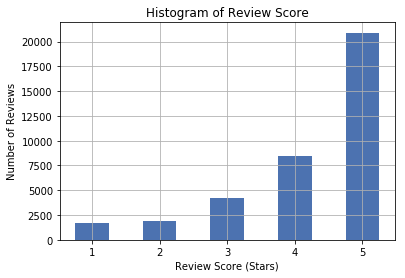

Number of five star reviews: 20890
Percent of five star reviews: 56.26784463718148 %
Number of one star reviews: 1718
Percent of one star reviews: 4.627484781554705 %


In [88]:
plt.figure()
hist_bins = [0.5,1.5,2.5,3.5,4.5,5.5]
dataframe['overall'].hist(bins=hist_bins,rwidth=0.5)
plt.title("Histogram of Review Score")
plt.xlabel("Review Score (Stars)")
plt.ylabel("Number of Reviews")
plt.show()
number_scores = len([score for score in dataframe['overall']])
number_one_stars = len([score for score in dataframe['overall'] if score==1])
number_five_stars = len([score for score in dataframe['overall'] if score==5])
print('Number of five star reviews:',number_five_stars)
print('Percent of five star reviews:',number_five_stars/number_scores*100,'%')
print('Number of one star reviews:',number_one_stars)
print('Percent of one star reviews:',number_one_stars/number_scores*100,'%')

The histogram shows that the review score of 5 is the most frequent in the observed data, occuring in 20,890 reviews, or 56% of the time. The review score of 1 is the least frequent, occuring in 1,718 reviews, or 4.6% of the time.

The frequency of each review score is directly related to the review score. That is to say, 5 star reviews are the most common, 4 star reviews the next most common, 3 star reviews the next most common, and so on. This indicates a bias in the data towards positive reviews. 

The positive slant in the reviews is not necessarily bad - it could simply mean that the products reviewed were good overall, or that reviewers are more likely to give positive reviews than negative reviews. However, it is important to keep the bias towards positive reviews in mind. Since fewer examples exist for negative reviews, it is possible that predicting negative reviews will be more difficult than predicting positive reviews.

### Visualizing Review Helpfulness

Next, we visualize two similar attributes: the number of people who found each review helpful and the number of people who found each review unhelpful. Since both of these variables are numeric, we visualize the distribution of each variable with a box plot.

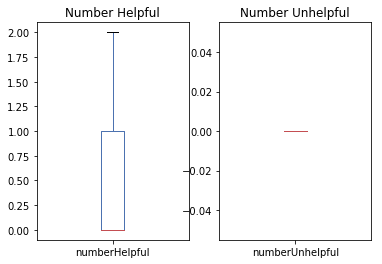

Maximum "helpful" tags: 484
Maximum "unhelpful" tags: 214


In [89]:
plt.figure()
plt.subplot(1, 2, 1)
helpful_boxplot = dataframe['numberHelpful'].plot(kind='box',showfliers=False)
plt.title('Number Helpful')
#plt.ylabel('Number Who Found the Review Helpful')
plt.subplot(1, 2, 2)
dataframe['numberUnhelpful'].plot(kind='box',showfliers=False)
plt.title('Number Unhelpful')
plt.show()
max_helpful = max(dataframe['numberHelpful'])
max_unhelpful = max(dataframe['numberUnhelpful'])
print('Maximum "helpful" tags:',max_helpful)
print('Maximum "unhelpful" tags:',max_unhelpful)

The above boxplots show that at least half of the reviews are not tagged as helpful, and at least three quarters of the reviews are not tagged as unhelpful. The majority of the data has no tags regarding helpfulness, which means predicting if a review is helpful or not from this dataset would be difficult.

Although most reviews have no tags, some of the reviews have a great many tags. For example, the largest number of helpful tags for a single review is 484, and the largest number of unhelpful tags for a single review is 214. To better visualize these outliers that don't show up in the boxplot, the two variables were also plotted in the histogram below.

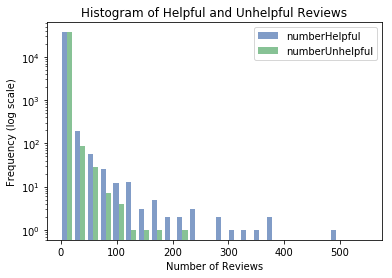

Number of reviews with over 100 "helpful" tags: 41
Number of reviews with over 100 "unhelpful" tags: 8


In [86]:
data=[dataframe['numberHelpful'],dataframe['numberUnhelpful']]
bins = np.linspace(0, 550, 25)
plt.yscale('log')
plt.hist(data, bins, alpha=0.7, label=['numberHelpful', 'numberUnhelpful'])
plt.legend(loc='upper right')
plt.title('Histogram of Helpful and Unhelpful Reviews')
plt.ylabel('Frequency (log scale)')
plt.xlabel('Number of Reviews')
plt.show()
helpful_over_100 = len([r for r in dataframe['numberHelpful'] if r>100])
unhelpful_over_100 = len([r for r in dataframe['numberUnhelpful'] if r>100])
print('Number of reviews with over 100 "helpful" tags:',helpful_over_100)
print('Number of reviews with over 100 "unhelpful" tags:',unhelpful_over_100)

The histogram uses a logarithmic scale on the y axis so that the outliers show up on the graph. The histogram shows that the vast majority of reviews are tagges as helpful or unhelpful fewer than 100 times. Only 41 reviews were tagged as helpful more than 100 times, and only 8 reviews were tagged as unhelpful more than 100 times.

A third variable that is directly related to the number of users who tagged a review helpful and the number of users who tagged a review unhelpful is the helpfulness ratio. The helpfulness ratio is simply the number of helpful tags divided by the total number of tags. Since the helpfulness ratio is numeric, it is visualized using a box plot.

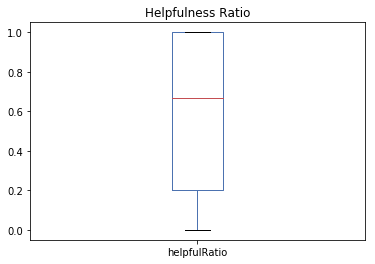

In [91]:
plt.figure()
dataframe['helpfulRatio'].plot(kind='box',showfliers=False)
plt.title('Helpfulness Ratio')
plt.show()

The box plot shows that the 25th percentile for the helpfulness ratio is 20%, the 50th percentile is 66%, and the 75th percentile is 100%. This means that at least 25% of the reviews that have been tagged as helpful or unhelpful are considered helpful unanimously.

### Number of reviews the reviewer has authored

Since the variable is numeric, its distribution is visualized by a boxplot.

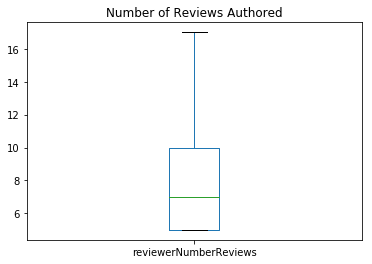

('Maximum number of reviews by a single reviewer:', 123)


In [24]:
plt.figure()
dataframe['reviewerNumberReviews'].plot(kind='box',showfliers=False)
plt.title('Number of Reviews Authored')
plt.show()
max_reviewed = max([r for r in dataframe['reviewerNumberReviews']])
print('Maximum number of reviews by a single reviewer:',max_reviewed)

The boxplot shows that the number of reviews each reviewer has authored has a 25th percentile of 5, a 50th percentile of 7, and a 75th percentile of 10. This means that 75% or more of reviewers have written 11 or fewer reviews.

Some reviewers, however, have written significantly more reviews, the meximum being 123.

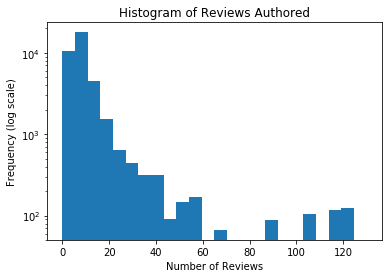

In [22]:
bins = np.linspace(0, 130, 25)
plt.hist(dataframe['reviewerNumberReviews'], bins,log=True)
plt.title('Histogram of Reviews Authored')
plt.ylabel('Frequency (log scale)')
plt.xlabel('Number of Reviews')
plt.show()